In [32]:
import numpy as np
from GPy.kern import RBF
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt

In [143]:
def evalute_2d(f, x_range, y_range, points_per_dim=50):
    x1_points = np.linspace(*x_range, points_per_dim)
    x2_points = np.linspace(*y_range, points_per_dim)

    X1, X2 = np.meshgrid(x1_points, x2_points)
    shape = X1.shape
    X = np.vstack((X1.flatten(), X2.flatten())).T
    Y = f(X).reshape(shape)
    return X1, X2, Y


# def gradient_plot(g, V=None, axis=None, marker='o', r=None):
#     # set axis ranges
#     if r is None:
#         r = 2*np.max(np.abs(g))
#     axis.set_xlim((-r,r))
#     axis.set_ylim((-r,r))
#     axis.grid(c='k', ls='-', alpha=0.1)

#     if V is not None:
#         f = lambda x: psd_norm_squared(x - g, V)
#         mesh = evalute_2d(f, (-r, r), (-r, r))
#         # cs = axis.contourf(*mesh, levels=[0., 1.], alpha=0.5)
#         cs = axis.contourf(*mesh, alpha=0.5)
#         cs2 = axis.contour(cs, colors='k')
#         axis.clabel(cs2, inline=1, fontsize=10)

#         # fig = plt.gcf()
#         # fig.colorbar(cs, cax=colorbar_axis)
#     axis.scatter([g[0]], [g[1]], marker=marker)


def contour2d(X1, X2, Y, axis, **kwargs):
    cs = axis.contourf(X1, X2, Y, **kwargs)
    axis.contour(cs, colors='k')
    axis.grid(c='k', ls='-', alpha=0.1)


def scatter2d(X, axis, **kwargs):
    X = np.atleast_2d(X).T
    axis.scatter(X[0], X[1], **kwargs)


In [156]:
x1 = np.array([[0,1], [0,2], [0,3]])
x2 = np.array([[10,1], [1,2], [0,4]])


In [161]:
rbf = RBF(input_dim=d)


np.vstack([x1, x2])

array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [10,  1],
       [ 1,  2],
       [ 0,  4]])

In [270]:
class GPRegression:
    def __init__(self, x_train, y_train, kernel, reg=1.):
        assert x_train.shape[0] == y_train.shape[0]
        self.num_train = x_train.shape[0]
        self.x_train = x_train
        self.y_train = y_train
        self.kernel = kernel
        self.reg = reg
        self.K = self.kernel(x_train, x_train) + self.reg*np.eye(self.num_train)
        self.chol_K = cho_factor(self.K)
    
    def predict(self, x_target):
        Ktx = self.kernel(x_target, self.x_train)
        Ktx_inv = cho_solve(self.chol_K, Ktx.T)
        mean = self.y_train @ Ktx_inv
        var = np.diag(self.kernel(x_target)) - np.sum(Ktx * Ktx_inv.T, axis=1)
        return mean, var
    
class DuelingGPRegression:
    
    def __init__(self, x1_train, x2_train, d_train, kernel, reg=1.):
        assert x1_train.shape[0] == d_train.shape[0]
        assert x2_train.shape[0] == d_train.shape[0]

        self.num_train = x1_train.shape[0]
        self.x1_train = x1_train
        self.x2_train = x2_train
        self.d_train = d_train
        self.kernel = kernel
        self.reg = reg
        self.K = self.kernel(x1_train, x1_train) \
                +self.kernel(x2_train, x2_train) \
                -self.kernel(x1_train, x2_train) \
                -self.kernel(x2_train, x1_train) \
                + self.reg*np.eye(self.num_train)
        self.chol_K = cho_factor(self.K)
        
    def precompute_target(self, xtarget):
        self._Ktx = self.kernel(xtarget, self.x1_train) - self.kernel(xtarget, self.x2_train) 
        self._Ktx_inv = cho_solve(self.chol_K, self._Ktx.T)
        self._xtarget = xtarget
    
    def mean(self):
        return self.d_train @ self._Ktx_inv
    
#     def full_covar(self, x_target):
#         return self.kernel(x_target) - self._Ktx @ self._Ktx_inv
    
    def var(self, x):
        x = np.atleast_2d(x)
        Ktx = self.kernel(x, self.x1_train) - self.kernel(x, self.x2_train) 
        Ktx_inv = cho_solve(self.chol_K, Ktx.T)
        return np.diag(self.kernel(x)) - np.sum(Ktx * Ktx_inv.T, axis=1)

    def psi(self, x_ref, x_target):
        x_ref = np.atleast_2d(x_ref)
        var_xref = self.var(x_ref)
        var_xtarget = np.diag(self.kernel(x_target)) - np.sum(self._Ktx * self._Ktx_inv.T, axis=1)
        
        Kt_ref = self.kernel(x_ref, self.x1_train) - self.kernel(x_ref, self.x2_train)
        covar = self.kernel(x_ref, x_target) - np.sum(Kt_ref* self._Ktx_inv.T, axis=1)
        return var_xref + var_xtarget - 2*covar

In [271]:
d = 1
n = 10
X1 = np.random.normal(size=d*n).reshape(n,d)
X2 = np.random.normal(size=d*n).reshape(n,d)


def f(x):
    x = np.sum(x, axis=1)
    return np.sin(x)


In [272]:

rbf = RBF(input_dim=d)
# rbf.K(x1, x2)
def my_rbf(x, x2=None):
    return rbf.K(x, x2)
# gp = GPRegression(X, f(X), my_rbf, reg=0.1)
# f(X)

D = f(X1) - f(X2)

gp = DuelingGPRegression(X1, X2, D, my_rbf, reg=0.1)



In [273]:
X_target = np.linspace(-2,2, 100).reshape(-1,d)

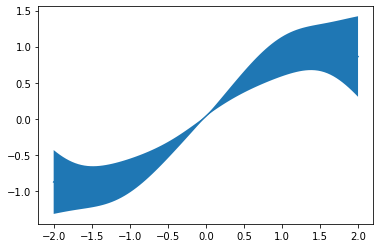

In [280]:
gp.precompute_target(X_target)
mean = gp.mean().flatten()
plt.plot(X_target.flatten(), mean)
x_ref = np.array([0.])
var = gp.psi(x_ref, X_target)
std = np.sqrt(var).flatten()
plt.fill_between(X_target.flatten(), mean -std, mean+std)

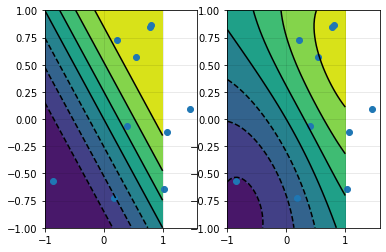

In [152]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
contour2d(*evalute_2d(f, (-1.,1,), (-1.,1.)), ax1)
scatter2d(X, ax1)

mean_eval = lambda x: gp.predict(x)[0]
contour2d(*evalute_2d(mean_eval, (-1.,1,), (-1.,1.)), ax2)
scatter2d(X, ax2)

ValueError: x and y must be the same size

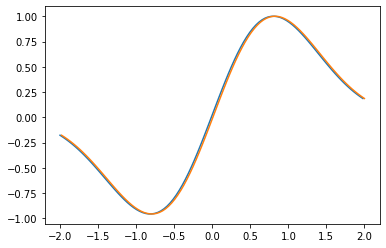

In [140]:
std = np.sqrt(var)
plt.plot(X_predict, mean)
plt.scatter(X, f(X))
plt.fill_between(X_predict.flatten(), mean - std, mean+std, alpha=0.3)

In [155]:
X1 = np.random.normal(size=12).reshape(3,4)
X2 = np.random.normal(size=12).reshape(3,4)


array([[ 0.        ,  7.74364502,  4.68589838],
       [-7.74364502,  0.        ,  5.34941857],
       [-4.68589838, -5.34941857,  0.        ]])

In [166]:
class Camelback:
    """
    Camelback benchmark function.
    """
    def __init__(self):
        super().__init__()
        self.d=2
        # self.x0 = np.array([0.5, 0.2])
        self.x0 = np.array([-0.12977758051079197, 0.2632096107305229])
        self.best_y = 1.03162842
        self.bounds = np.array([[-2,2],[-1,1]])

    def exact(self, x):
        x = np.atleast_2d(x)
        xx = x[:,0]
        yy = x[:,1]
        y = (4. - 2.1*xx**2 + (xx**4)/3.)*(xx**2) + xx*yy + (-4. + 4*(yy**2))*(yy**2)
        return np.maximum(-y, -2.5)

    def __call__(self, x):
        x = np.atleast_2d(x)
        return self.exact(x) + np.random.normal(scale=0.1, size=x.shape[-2])

In [167]:
camelback = Camelback()

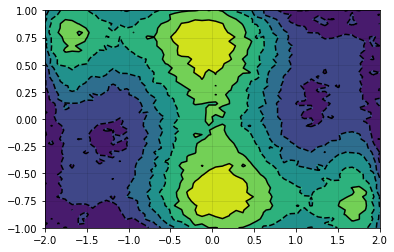

In [168]:
fig, ax1 = plt.subplots(ncols=1)
contour2d(*evalute_2d(camelback, (-2.,2,), (-1.,1.)), ax1)

In [202]:
def get_grid(*bounds, points_per_dim=50):
    points = [np.linspace(*lim, points_per_dim) for lim in bounds]
#     print(points)
#     return points
#     X = np.vstack((X1.flatten(), X2.flatten())).T

    return np.vstack([x.flatten() for x in np.meshgrid(*points)]).T

In [208]:
get_grid(*np.array([[0,1],[0,1]]), points_per_dim=5).shape

(25, 2)

In [209]:
np.random.choice(np.array([[0,1],[0,1]]))

ValueError: a must be 1-dimensional